# Calibration of PS scintillator with two samples:
>only Compton edges visible:
>
>$^{137}$Cs: 477 keV
>   
>$^{22}$Na: 341 keV, 1064 keV

In [1]:
# %load ../../tools.py
def uc_str(c, max_digit=4):
    """
    input format: uc.ufloat
    rounds float and corrisponding error to last significant digit
    returns float and error as string
    as integers with max max_digit (=4) error digits
    as floats with max 4 error digits
    as exp else
    """
    digit = -int(np.floor(np.log10(c.s)))    
    if (c.s * 10**digit) < 1.5: # convention...
        digit += 1
    c_r = round(c.n, digit)
    s_c_r = round(c.s, digit)
    if (-3 < digit) * (digit <= 0): # returns readable integers
        c_str = '%i \pm %i'%(c_r, s_c_r)
    elif (0 < digit) * (digit < (max_digit + 1)): # returns readable floats (max 3 digits)
        c_str = ('%.' + str(digit) + 'f \pm %.' + str(digit) + 'f')%(c_r, s_c_r)
    else: # returns exp
        c_str = ('(%.1f \pm %.1f)\mathrm{e}%i')%(c_r * 10**(digit-1), s_c_r * 10**(digit-1), -(digit-1))
    return c_str

def enum(arr1, *args):
    i_range = range(len(arr1))
    return zip(i_range, arr1 ,*args)


In [2]:
# %load "../../style.py"
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit

sns.set(style='ticks', palette='Set2') 
sns.despine()

# These are the colors. Notice how this is programmed:
# You initialize your colors by 
# colorset = palette()
# then you can cycle through the colors:
# color = next(colorset)
# if you want your set to be reset, just create
# a new palette() instance! This way the colors do not interfere.

color_names = ['windows blue', "pale red", "faded green", "amber", 
          'dark green', 'dark fuchsia', 'browny orange', 
          'puke green', 'dark royal blue', 'dusty purple', 'red orange']
colors = sns.xkcd_palette(color_names)
palette = lambda: itertools.cycle(sns.xkcd_palette(color_names) )

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['legend.markerscale'] = 4
rcParams['axes.titlesize'] = fontsize_labels
rcParams['text.color'] = "0.3"
rcParams['xtick.color'] = "0.3"
rcParams['ytick.color'] = "0.3"
rcParams['axes.labelcolor'] = "0.3"
rcParams['axes.edgecolor'] = "0.8"

xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  

save_fig = True
if not save_fig:
        rcParams['figure.figsize'] = (13, 8) 
fig_dir = "./figures/"  # directory of figures

def fixticks(ax):    
    for t in ax.xaxis.get_ticklines(): t.set_color('0.8')
    for t in ax.yaxis.get_ticklines(): t.set_color('0.8')


In [3]:
# %load "../../preamb.py"
import numpy as np
import uncertainties as uc
import uncertainties.unumpy as un
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter as sav
from scipy.special import erfc
from scipy.integrate import quad
import sys

npy_dir = "./data_npy/"

In [4]:
def conv_analytical(x, *p):
    '''
    analytical solution of convolution of step and gauss
    as a crude approximation of klein nishima
    '''
    A_edge, x_step, sigma, offset = p
    return A_edge / 2 * erfc((x - x_step) / (np.sqrt(2) * sigma))  + offset

def two_edges(x, *p):
    '''
    analytical solution of convolution of step and gauss
    as a crude approximation of klein nishima
    '''
    A_edge1, x_step1, sigma1, A_edge2, x_step2, sigma2, offset = p
    edges = A_edge1 / 2 * erfc((x - x_step1) / (np.sqrt(2) * sigma1)) \
    + A_edge2 / 2 * erfc((x - x_step2) / (np.sqrt(2) * sigma2)) \
    + offset
    return edges

Background
----------------

In [5]:
#### Background ####
file = "ps_background_02"

file_in = npy_dir + file + '.npy'
x_bg, y_bg = np.load(file_in)
y_bg_e = un.uarray(y_bg, np.maximum(1, np.sqrt(y_bg)))

t_bg = 56094.804  # Real time
rate_bg = y_bg / t_bg
rate_bg_e = y_bg_e / t_bg

x_lower = 50

print("%.3f"%(t_bg/3600))

15.582


$^{22}$Na Sample
----------------

/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


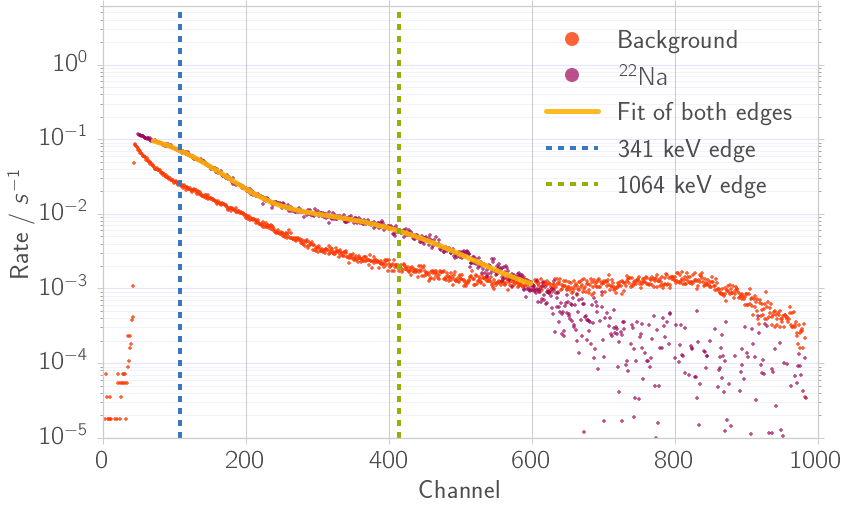

In [6]:
#### 22Na sample ####
na_sample = '$^{22}\mathrm{Na}$'
file_in = npy_dir + "ps_22na_06" + '.npy'
x, y = np.load(file_in)
y_e = un.uarray(y, np.maximum(1, np.sqrt(y)))

t_na = 59302.371   
rate = y / t_na
rate = rate - rate_bg
rate[rate < 0] = 0
rate[x < x_lower] = 0

rate_e = y_e / t_na - rate_bg_e
rate_e[rate < 0] = 0 
rate_e[x < x_lower] = 0

y = rate
y_filtered = sav(y, 301, 4)
y_e = rate_e

###### BOTH COMPTON EDGES #################
# Define range to be fitted
x_min = 70   # lower bound
x_max = 600    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit = x[mask]
y_fit = y[mask]
y_sigma = un.std_devs(y_e[mask])


# p0 is the initial guess for the fitting coefficients
# p = [A_edge, x_step, sigma, offset]
p0 = [0.23, 110, 96, 0.015,  440,   130,   1.3e-4]
#fit_edge0 = two_edges(x_fit, *p0)
coeff, cov = curve_fit(two_edges, x_fit, y_fit, p0=p0, 
                              sigma=y_sigma, absolute_sigma=True)
cor = uc.correlated_values(coeff, cov)
fit_edge = two_edges(x_fit, *coeff)
x_step1 = coeff[1]
x_step2 = coeff[4]


# Plotting
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)

if not save_fig:
    fig1.suptitle("Histogram PS, sample: " + na_sample)
ax1.plot(x, rate_bg, '.', color= colors[-1], alpha=0.8, label='Background')
ax1.plot(x, rate, '.', color= colors[5], alpha=0.7, label=(na_sample))

ax1.plot(x_fit, fit_edge, '-', color=colors[3], alpha=0.9, label='Fit of both edges', linewidth = 5)
ax1.plot([x_step1] * 2, [0, 8000], '--', color=colors[0], label='341 keV edge',linewidth = 4)
ax1.plot([x_step2] * 2, [0, 8000], '--', color=colors[7], label='1064 keV edge',linewidth = 4)
#edge2, = ax1.plot(x_fit2, fit_edge2, '-', alpha=0.8, label='1064 keV edge fit')
#ax1.plot([x_step2] * 2, [0, 8000], '--', c=edge2.get_color(), label='1064 keV edge')
ax1.set_xlabel("Channel")
ax1.set_ylabel("Rate / $s^{-1}$")
ax1.set_xlim(0, 1000)
ax1.set_ylim(1e-5, 6)
#ax1.set_ylim(1e-5, .1)
ax1.legend(loc=1, markerscale= 4)
ax1.grid(True)
ax1.set_yscale("log", nonposy='clip')

ax1.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = 0.1)
ax1.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = 0.1)
ax1.xaxis.grid(True)


file_name = "calib_ps_na"

#if show_fig:
    #fig1.show()
if save_fig:
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")

In [7]:
[print(uc_str(num)) for num in cor]

0.119 \pm 0.003
108 \pm 2
69 \pm 2
0.0102 \pm 0.0004
414 \pm 4
104 \pm 5
(7.8 \pm 1.1)\mathrm{e}-4


[None, None, None, None, None, None, None]

In [8]:
uc.correlation_matrix((cor[1],cor[4]))

array([[ 1.        , -0.54004571],
       [-0.54004571,  1.        ]])

$^{137}$Cs Sample
-----------------

/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


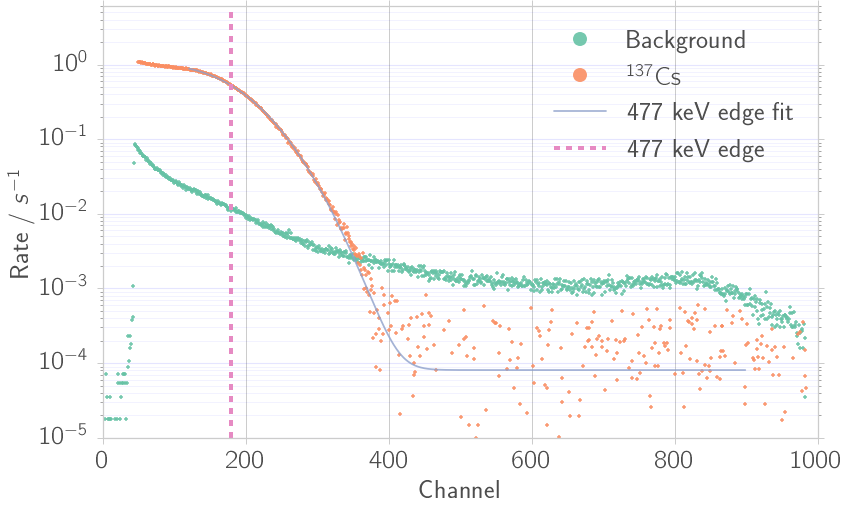

In [9]:
#### 137Cs sample ####
cs_sample = '$^{137}\mathrm{Cs}$'
file_in = npy_dir + "ps_137cs_04" + '.npy'
x, y = np.load(file_in)
y_e = un.uarray(y, np.sqrt(np.maximum(y,1)))

t_ps = 21386.496 # look for data/ps_cs137_04.mcd
rate = y / t_ps
rate = rate - rate_bg
rate[rate < 0] = 0
rate[x < x_lower] = 0

rate_e = y_e / t_ps - rate_bg_e
rate_e[rate < 0] = 0 
rate_e[x < x_lower] = 0

y = rate
y_filtered = sav(y, 301, 4)
y_e = rate_e


###### 477 keV COMPTON EDGE #################
# Define range to be fitted
x_min = 120   # lower bound
x_max = 900    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit3 = x[mask]
y_fit3 = y[mask]
y_sigma = un.std_devs(y_e[mask])

# p0 is the initial guess for the fitting coefficients
# p = [A_edge, x_step, sigma, offset]
p0 = [ 0.4,  220,   70,   5e-4]
#fit_edge0 = conv_analytical(x_fit3, *p0)
coeff3, cov3 = curve_fit(conv_analytical, x_fit3, y_fit3, p0=p0, 
                              sigma=y_sigma, absolute_sigma=True)
c3 = uc.correlated_values(coeff3, cov3)
fit_edge3 = conv_analytical(x_fit3, *coeff3)
x_step3 = coeff3[1]


# Plotting
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
if not save_fig:
    fig1.suptitle("Histogram PS, sample: "+ cs_sample)
ax1.plot(x, rate_bg, '.', alpha=0.9, label='Background')
ax1.plot(x, rate, '.', alpha=0.9, label=(cs_sample))
edge3, = ax1.plot(x_fit3, fit_edge3, '-', alpha=0.8, label='477 keV edge fit')
ax1.plot([x_step3] * 2, [0, 8000], '--', c=edge3.get_color(), label='477 keV edge',linewidth = 4)
ax1.set_xlabel("Channel")
ax1.set_ylabel("Rate / $s^{-1}$")
ax1.set_xlim(0, 1000)
ax1.set_ylim(1e-5, 6)
ax1.legend(loc=1)
ax1.grid(True)
ax1.set_yscale("log", nonposy='clip')

ax1.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = 0.1)
ax1.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = 0.1)
ax1.xaxis.grid(True)


file_name = "calib_ps_cs"
if save_fig:
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")


In [10]:
[print(uc_str(num)) for num in c3]

1.064 \pm 0.004
178.9 \pm 0.3
60.9 \pm 0.2
(8.1 \pm 1.2)\mathrm{e}-5


[None, None, None, None]

In [11]:
t_ps/ 3600

5.940693333333333

### Save parameters

In [12]:
na_compton1 = uc.ufloat(coeff[1], cov[1, 1])
na_compton2 = uc.ufloat(coeff[4], cov[4, 4])
cs_compton  = uc.ufloat(coeff3[1], cov3[1, 1])

# Use sigma for errors!
#na_compton1 = uc.ufloat(coeff[1], coeff[2])
#na_compton2 = uc.ufloat(coeff[4], coeff[5])
#cs_compton  = uc.ufloat(coeff3[1], coeff3[2])

# Calibration by linear fitting
* $^{22}$Na Compton edge 1: 341 keV
* $^{22}$Na Compton edge 2: 1064 keV
* $^{137}$Cs Compton edge: 477 keV

In [30]:
energy = np.array([341, 1064, 477])
fit_results = np.array([cor[1], cor[4], c3[1]])
channel = un.nominal_values(fit_results)
channel_error = un.std_devs(fit_results)
def linear(x, a, b):
    return (a*x + b)

coeff_lin, cov_lin = curve_fit(linear, energy, channel, p0=None, 
                               sigma=np.sqrt(channel_error), absolute_sigma=True)
chi2 = np.sum(((linear(energy,*coeff_lin) - channel)/channel_error)**2 )/ (len(channel) - 2)

c_lin = uc.correlated_values(coeff_lin, cov_lin)
# Switch to energy(channel):
d_lin = np.array([1 / c_lin[0], -c_lin[1] / c_lin[0]])
np.save(npy_dir + 'ps_calibration', d_lin)

/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


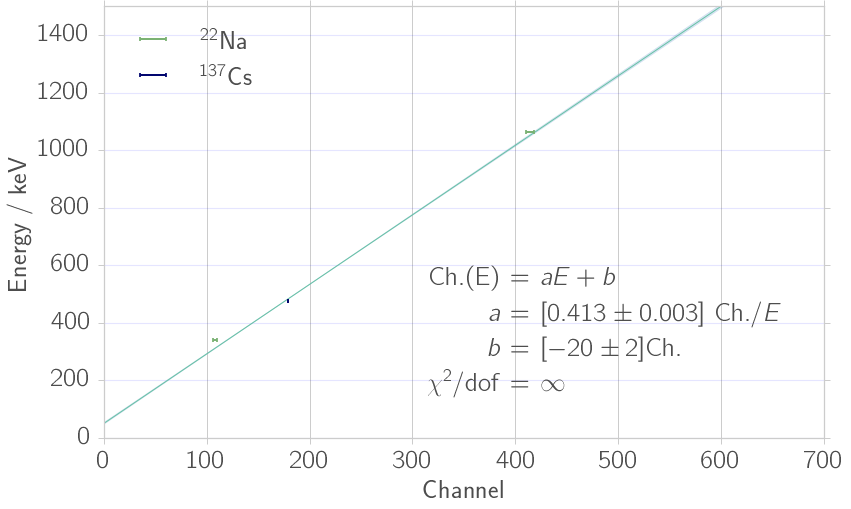

In [29]:
# Plotting
channel_min, channel_max = [0, 700]
chs = np.linspace(channel_min, channel_max, 200)
fit = linear(chs, *d_lin)

fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
if not save_fig:
    fig1.suptitle('Calibration of PS scintillator: Linear fit')
ax1.fill_between(chs, 
        un.nominal_values(fit) + un.std_devs(fit),
        un.nominal_values(fit) - un.std_devs(fit),
        facecolor=colors[0], color=colors[0], alpha=0.2)
ax1.plot(chs, un.nominal_values(fit), '-', linewidth=1.0)  

ax1.errorbar(channel[0:2], energy[0:2], xerr=channel_error[0:2], yerr=None, fmt=',',\
             elinewidth=2.0, capsize=2.2, capthick=1.8, label = "$^{22}$Na", color = colors[2])

ax1.errorbar(channel[2], energy[2], xerr=channel_error[2], yerr=None, fmt=',',\
             elinewidth=2.0, capsize=2.2, capthick=1.8, label = "$^{137}$Cs", color = colors[-3])
ax1.legend(loc = 2)
ax1.set_xlim(channel_min, channel_max)
ax1.set_ylim(0, 1500)
ax1.set_xlabel("Channel")
ax1.set_ylabel("Energy / keV")

ax1.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = 0.1)
ax1.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = 0.1)
ax1.xaxis.grid(True)

props = dict(boxstyle='round', facecolor='white', alpha=0.0)

textstr = "\\begin{eqnarray*} \
        \\ \\mathrm{Ch.(E)} &=& a E + b \\\\ \
        \\ a &=&[%s]\\ \\mathrm{Ch.}/E \\\\ \
        \\ b &=&[%s]\\mathrm{Ch.} \\\\ \
        \\ \chi^2/\mathrm{dof} &=& \infty \
        \end{eqnarray*}"%(uc_str(c_lin[0]),uc_str(c_lin[1]))
#textstr = r"\begin{align*}\mathrm{Ch.(E)} & = a E + b \n a & =["\
#+uc_str(c_lin[0])+r"]\:\frac{\mathrm{Ch.}}{E}\n \: b & =["+uc_str(c_lin[1])+r"]\:\mathrm{Ch.}\end{align*}"
#textstr = r"\begin{equation*}"+"\n"+" \mathrm{Ch.(E)} = a E + b"+"\n"+"\end{equation*}"
ax1.text(0.45, 0.4, textstr , transform=ax1.transAxes,
        verticalalignment='top', bbox=props)

if save_fig:
    file_name = "calibration_ps_linear_fit"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")

In [21]:
chi2

array([ 67.46881576,   6.17732222,  14.70318865])